In [1]:
# -*- coding: utf-8 -*-
import os
import gc
import argparse
import json
import random
import math
import random
from functools import reduce
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report
import torch
from torch import nn
from torch.optim import Adam, SGD, AdamW
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts, CyclicLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from tqdm import tqdm

from performer_pytorch import PerformerLM
import scanpy as sc
import anndata as ad
from utils import *
from datetime import datetime
from time import time
import torch.multiprocessing as mp
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
from torch.utils.tensorboard import SummaryWriter

from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
#read Zheng data
zheng_data = sc.read_h5ad("/data/rna_rep_learning/scBERT/Zheng68K.h5ad")
zheng_data

AnnData object with n_obs × n_vars = 68450 × 16906
    obs: 'TSNE.1', 'TSNE.2', 'celltype', 'n_genes'
    uns: 'log1p'

In [3]:
data = zheng_data.X
label = zheng_data.obs.celltype

In [11]:
NREPS = 10
SAMPLING_FRACS = [1.0]

ks = []
fracs = []
cs=[]
train_accs = []
test_accs = []
test_f1s = []
for k in np.arange(NREPS):
    for frac in SAMPLING_FRACS:
        ks.append(k)
        fracs.append(frac)
        print("frac {}, rep {}".format(frac, k))
        #downsample training set
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2022) #update Aug 2023: hold train/val across all runs #same train/val set split for each frac in k
        for index_train, index_val in sss.split(data, label):
            np.random.seed(k)
            index_train_small = np.random.choice(index_train, round(index_train.shape[0]*frac), replace=False)
            X_train, y_train = data[index_train_small], label[index_train_small]
            X_test, y_test = data[index_val], label[index_val]

        print("Loaded data...")

        #train on train_dataset
        
        """ c=0.1 was always best, using going forward without always running tuning
        #hyperparameter tune using k-fold val on training data
        cv_results = {}
        for c in [1e-3, 1e-2, 1e-1, 1]:
            print("c={}".format(c))
            lr = LogisticRegression(random_state=0, penalty="l1", C=c, solver="liblinear")
            res = cross_validate(lr, X_train, y_train, scoring=['accuracy'])
            cv_results[c] = np.mean(res['test_accuracy'])
        print(cv_results)

        #choose best c and calc performance on val_dataset
        best_ind = np.argmax(list(cv_results.values()))
        c = list(cv_results.keys())[best_ind]
        cs.append(c)
        """
        c = 0.1
        #print("best c={}".format(c))
        lr = LogisticRegression(penalty="l1", C=c, solver="liblinear") #random_state=0, 
        lr.fit(X_train, y_train)
        train_acc = lr.score(X_train, y_train)
        test_acc = lr.score(X_test, y_test)
        print("train set accuracy: " + str(np.around(train_acc, 4)))
        print("test set accuracy: " + str(np.around(test_acc, 4)))
        val_macro_f1 = f1_score(y_test, lr.predict(X_test), average="macro")
        print("test set macro F1: " + str(np.around(val_macro_f1, 4)))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        test_f1s.append(val_macro_f1)
        
        print("\n")
        


frac 1.0, rep 0
Loaded data...
train set accuracy: 0.9461
test set accuracy: 0.8117
test set macro F1: 0.707


frac 1.0, rep 1
Loaded data...
train set accuracy: 0.9461
test set accuracy: 0.8116
test set macro F1: 0.7072


frac 1.0, rep 2
Loaded data...
train set accuracy: 0.946
test set accuracy: 0.8116
test set macro F1: 0.7071


frac 1.0, rep 3
Loaded data...
train set accuracy: 0.9461
test set accuracy: 0.8111
test set macro F1: 0.7065


frac 1.0, rep 4
Loaded data...
train set accuracy: 0.9461
test set accuracy: 0.8112
test set macro F1: 0.7068


frac 1.0, rep 5
Loaded data...
train set accuracy: 0.9461
test set accuracy: 0.8117
test set macro F1: 0.7075


frac 1.0, rep 6
Loaded data...
train set accuracy: 0.9461
test set accuracy: 0.8115
test set macro F1: 0.707


frac 1.0, rep 7
Loaded data...
train set accuracy: 0.9461
test set accuracy: 0.8119
test set macro F1: 0.7074


frac 1.0, rep 8
Loaded data...
train set accuracy: 0.9461
test set accuracy: 0.8115
test set macro F1: 0.70

## How does LR perform on "hard" cell types?

In [21]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2022) #update Aug 2023: hold train/val across all runs #same train/val set split for each frac in k
for index_train, index_val in sss.split(data, label):
    X_train, y_train = data[index_train], label[index_train]
    X_test, y_test = data[index_val], label[index_val]

c = 0.1
lr = LogisticRegression(penalty="l1", C=c, solver="liblinear") #random_state=0, 
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [31]:
# val accuracy
lr.score(X_test[y_test.isin(['CD8+ Cytotoxic T','CD8+/CD45RA+ Naive Cytotoxic']),:], y_test[y_test.isin(['CD8+ Cytotoxic T','CD8+/CD45RA+ Naive Cytotoxic'])])

0.8482620320855615

In [27]:
#val F1
f1_score(y_test, lr.predict(X_test), average='macro', labels=['CD8+ Cytotoxic T','CD8+/CD45RA+ Naive Cytotoxic'])

0.8275980602242234

## Sample efficiency

In [12]:
#only run the sampling experiment 3 times
NREPS = 3
SAMPLING_FRACS = [0.75, 0.5, 0.25, 0.1]

#ks = []
#fracs = []
#cs=[]
#train_accs = []
#test_accs = []
#test_f1s = []
for k in np.arange(NREPS): 
    for frac in SAMPLING_FRACS:
        ks.append(k)
        fracs.append(frac)
        print("frac {}, rep {}".format(frac, k))
        #downsample training set
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2022) #update Aug 2023: hold train/val across all runs #same train/val set split for each frac in k
        for index_train, index_val in sss.split(data, label):
            np.random.seed(k)
            index_train_small = np.random.choice(index_train, round(index_train.shape[0]*frac), replace=False)
            X_train, y_train = data[index_train_small], label[index_train_small]
            X_test, y_test = data[index_val], label[index_val]

        print("Loaded data...")

        #train on train_dataset
        
        """ c=0.1 was always best, using going forward without always running tuning
        #hyperparameter tune using k-fold val on training data
        cv_results = {}
        for c in [1e-3, 1e-2, 1e-1, 1]:
            print("c={}".format(c))
            lr = LogisticRegression(random_state=0, penalty="l1", C=c, solver="liblinear")
            res = cross_validate(lr, X_train, y_train, scoring=['accuracy'])
            cv_results[c] = np.mean(res['test_accuracy'])
        print(cv_results)

        #choose best c and calc performance on val_dataset
        best_ind = np.argmax(list(cv_results.values()))
        c = list(cv_results.keys())[best_ind]
        cs.append(c)
        """
        c = 0.1
        #print("best c={}".format(c))
        lr = LogisticRegression(penalty="l1", C=c, solver="liblinear") #random_state=0, 
        lr.fit(X_train, y_train)
        train_acc = lr.score(X_train, y_train)
        test_acc = lr.score(X_test, y_test)
        print("train set accuracy: " + str(np.around(train_acc, 4)))
        print("test set accuracy: " + str(np.around(test_acc, 4)))
        val_macro_f1 = f1_score(y_test, lr.predict(X_test), average="macro")
        print("test set macro F1: " + str(np.around(val_macro_f1, 4)))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        test_f1s.append(val_macro_f1)
        
        print("\n")
        


frac 0.75, rep 0
Loaded data...
train set accuracy: 0.9527
test set accuracy: 0.8012
test set macro F1: 0.7028


frac 0.5, rep 0
Loaded data...
train set accuracy: 0.9618
test set accuracy: 0.7842
test set macro F1: 0.6798


frac 0.25, rep 0
Loaded data...
train set accuracy: 0.9743
test set accuracy: 0.7515
test set macro F1: 0.6433


frac 0.1, rep 0
Loaded data...
train set accuracy: 0.977
test set accuracy: 0.7164
test set macro F1: 0.6092


frac 0.75, rep 1
Loaded data...
train set accuracy: 0.9528
test set accuracy: 0.7977
test set macro F1: 0.6933


frac 0.5, rep 1
Loaded data...
train set accuracy: 0.9593
test set accuracy: 0.7791
test set macro F1: 0.6669


frac 0.25, rep 1
Loaded data...
train set accuracy: 0.9706
test set accuracy: 0.7531
test set macro F1: 0.6402


frac 0.1, rep 1
Loaded data...
train set accuracy: 0.9788
test set accuracy: 0.7188
test set macro F1: 0.5995


frac 0.75, rep 2
Loaded data...
train set accuracy: 0.9521
test set accuracy: 0.7984
test set macro F

In [6]:
#check accuracy per tissue class
for ct in np.unique(zheng_data.obs.celltype):
    print(ct+": {}".format(lr.score(X_test[y_test==ct], y_test[y_test==ct])))

CD14+ Monocyte: 0.8982456140350877
CD19+ B: 0.8382978723404255
CD34+: 0.8125
CD4+ T Helper2: 0.05
CD4+/CD25 T Reg: 0.6814874696847211
CD4+/CD45RA+/CD25- Naive T: 0.4732620320855615
CD4+/CD45RO+ Memory: 0.4297385620915033
CD56+ NK: 0.9264957264957265
CD8+ Cytotoxic T: 0.8075162611418936
CD8+/CD45RA+ Naive Cytotoxic: 0.8993691799339141
Dendritic: 0.7613365155131265


# Visualization

In [16]:
res_df = pd.DataFrame({'model': np.repeat('logistic regression', 22), 'k':ks, 'frac_training_data':fracs, 'test_acc':test_accs, 'test_f1':test_f1s})

In [17]:
res_df.to_csv("sampleeff_LR_metrics.csv", index=False)

In [18]:
res_df.groupby('frac_training_data').mean()

,k,test_acc,test_f1
frac_training_data,,,
0.10,1.0,0.718359,0.603554
0.25,1.0,0.751838,0.640603
0.50,1.0,0.780034,0.671881
0.75,1.0,0.799099,0.696308
1.00,4.5,0.811519,0.707050


<AxesSubplot:xlabel='frac_training_data', ylabel='test_acc'>

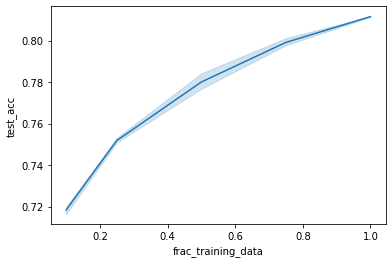

In [19]:
sns.lineplot(data=res_df, x="frac_training_data", y="test_acc")#, hue="exp")
